In [1]:
from scipy.signal import fftconvolve, convolve2d
from astropy.io import fits
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis
%matplotlib inline

In [4]:
simulation = "/scratch/datasets/kat7_2000/raw/"
neural_output = "/home/gijs/Work/astro-pix2pix/test/rewrite/fits/"

In [5]:
std_wsclean = []
std_neural = []
mean_wsclean = []
mean_neural = []
skew_wsclean = []
skew_neural = []
kurtosis_wsclean = []
kurtosis_neural = []


for number in range(1800, 1899):
    psf_path = "{}{}-bigpsf-psf.fits".format(simulation, number)
    outputs_path = "{}{}-outputs.fits".format(neural_output, number)
    image_path = "{}{}-wsclean-image.fits".format(simulation, number)
    skymodel_path = "{}{}-skymodel.fits".format(simulation, number)
    dirty_path = "{}{}-wsclean-dirty.fits".format(simulation, number)
    model_path = "{}{}-wsclean-model.fits".format(simulation, number)
    convolved_path = "{}{}-convoled.fits".format(simulation, number)
    residual_path = "{}{}-wsclean-residual.fits".format(simulation, number)

    psf = fits.open(psf_path)[0].data.squeeze()
    psf = psf / psf.max()
    output = fits.open(outputs_path)[0].data.squeeze()    # the output of the neural network
    skymodel = fits.open(skymodel_path)[0].data.squeeze() # the skymodel used as input to the telescope sim pipeline
    dirty = fits.open(dirty_path)[0].data.squeeze()       # dirty image created by wsclean
    image = fits.open(image_path)[0].data.squeeze()       # cleaned image created by wsclean
    residual_wsclean = fits.open(residual_path)[0].data.squeeze()       # cleaned image created by wsclean
    model_wsclean = fits.open(model_path)[0].data.squeeze()       # cleaned image created by wsclean

    p = psf.shape[0]
    r = slice(p//2, -p//2+1)    # uneven PSF needs +2, even psf +1
    convolved_neural = fftconvolve(output, psf, mode="full")[r,r]

    convolved_neural = convolved_neural * (dirty.max() / convolved_neural.max())

    residual_neural = dirty - convolved_neural
    if np.std(residual_neural):
        std_wsclean.append(np.std(residual_wsclean))
        std_neural.append(np.std(residual_neural))
    if np.mean(residual_neural):
        mean_wsclean.append(np.mean(residual_wsclean))
        mean_neural.append(np.abs(np.mean(residual_neural)))
    if skew(residual_neural.flatten()):
        skew_wsclean.append(skew(residual_wsclean.flatten()))
        skew_neural.append(skew(residual_neural.flatten()))
    if kurtosis(residual_neural.flatten()):
        kurtosis_wsclean.append(kurtosis(residual_wsclean.flatten()))
        kurtosis_neural.append(kurtosis(residual_neural.flatten()))

In [6]:
m = max(std_wsclean + std_neural)

Text(0.5,1,'kurtosis')

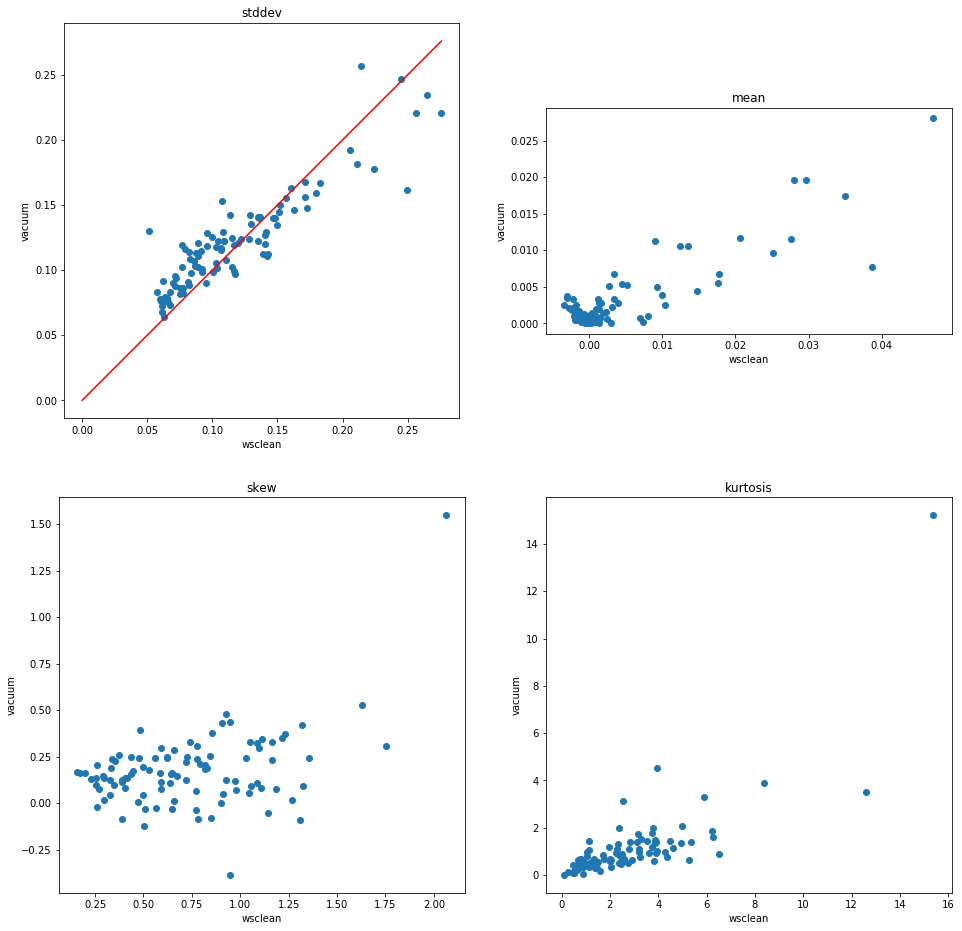

In [7]:
f, ((a1, a2), (a3, a4)) = plt.subplots(2, 2, figsize=(16,16))
a1.plot(std_wsclean, std_neural, 'o')
a1.plot([0, m], [0, m], 'r-')
a1.set_xlabel('wsclean')
a1.set_ylabel('vacuum')
a1.set_title('stddev')
a1.set_aspect('equal')
a2.plot(mean_wsclean, mean_neural, 'o')
a2.set_xlabel('wsclean')
a2.set_ylabel('vacuum')
a2.set_title('mean')
a2.set_aspect('equal')
a3.plot(skew_wsclean, skew_neural, 'o')
a3.set_xlabel('wsclean')
a3.set_ylabel('vacuum')
a3.set_title('skew')
#a3.set_aspect('equal')
a4.plot(kurtosis_wsclean, kurtosis_neural, 'o')
a4.set_xlabel('wsclean')
a4.set_ylabel('vacuum')
a4.set_title('kurtosis')
#a4.set_aspect('equal')

In [8]:
range(1800, 1899)[np.argmax(std_neural)]

1854

In [9]:
range(1800, 1899)[np.argmin(np.array(std_neural) - np.array(std_wsclean))]

1896